### Problem Statement

**Goal:**
The goal of the problem is to predict whether a client will default on the loan payment or not. For each ID in the test_data, you must predict the “default” level.


**Datasets**
The problem contains two datasets, Train Data, and Test Data. Model building is to be done on Train Dataset and the Model testing is to be done on Test Dataset. The output from the Test Data is to be submitted in the Hackathon platform


**Metric to measure**
Your score is the percentage of all correct predictions made by you. This is simply known as accuracy. The best accuracy is 1 whereas the worst is 0. It will be calculated as the total number of two correct predictions (True positive + True negative) divided by the total number of observations in the dataset.


**Submission File Format:**
You should submit a CSV file with exactly 39933 entries plus a header row.
The file should have exactly two columns

*         ID ( sorted in any order)

*         default (contains 0 & 1, 1 represents default)


**Train data set file**
* Train_set.csv

**Test data set file**
* Test_set.csv
    
**Sample submission file**
* Sample_Submission_(2).csv

**Additional files**
* Data_Dictionary_(1).csv


**Data Dictionary**

* **ID:** unique ID assigned to each applicant
* **loan_amnt:** loan amount ($) applied each applicant
* **loan_term:** Loan duration in years
* **interest_rate:** Applicable interest rate on Loan in %
* **loan_grade:** Loan Grade Assigned by the bank
* **loan_subgrade:** Loan SubGrade Assigned by the bank
* **job_experience:** Number of years job experience 
* **home_ownership:** Status of House Ownership
* **annual_income:** Annual income of the applicant
* **income_verification_status:** Status of Income verification by the bank
* **loan_purpose:** Purpose of loan
* **state_code:** State code of the applicant's residence 
* **debt_to_income:** Ratio to total debt to income (total debt might include other loan aswell)
* **delinq_2yrs:** number of 30+ days delinquency in past 2 years
* **public_records:** number of legal cases against the applicant
* **revolving_balance:** total credit revolving balance
* **total_acc:** total number of credit lines available in members credit line
* **interest_receive:** total interest received by the bank on the loan
* **application_type:** Whether the applicant has applied the loan by creating individuall or joint account
* **last_week_pay:** How many months have the applicant paid the loan EMI already
* **total_current_balance:** total current balance of all the accounts of applicant
* **total_revolving_limit:** total revolving credit limit
* **default:** "status of loan amount, 1 = Defaulter, 0 = Non Defaulters"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb 19 20:12:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## **Introductory Steps**

### Importing Libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import random
from tensorflow.keras import backend

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

random.seed(1)
np.random.seed(1) 
tf.random.set_seed(1)
warnings.filterwarnings("ignore")

### Loading the Data

In [5]:
Data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Hackathons/Train_set.csv')

In [6]:
# Checking the number of rows and columns in the data
Data.shape

(93174, 23)

* The dataset has 93174 rows and 23 columns

In [7]:
Data_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Hackathons/Test_set.csv')

In [8]:
Data_test.shape

(39933, 22)

## **Data Preprocessing**

### Train data Load

In [184]:
# copy dataframe to another one for modifying 
df = pd. DataFrame(Data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93174 entries, 0 to 93173
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          93174 non-null  int64  
 1   loan_amnt                   93174 non-null  int64  
 2   loan_term                   93174 non-null  object 
 3   interest_rate               93174 non-null  float64
 4   loan_grade                  93174 non-null  object 
 5   loan_subgrade               93174 non-null  object 
 6   job_experience              88472 non-null  object 
 7   home_ownership              93174 non-null  object 
 8   annual_income               93173 non-null  float64
 9   income_verification_status  93174 non-null  object 
 10  loan_purpose                93174 non-null  object 
 11  state_code                  93174 non-null  object 
 12  debt_to_income              93174 non-null  float64
 13  delinq_2yrs                 931

In [185]:
# ID columns consists of uniques ID for customers and hence will not add value to the modeling
df.drop(['ID'],axis=1,inplace=True)

In [186]:
df.isna().sum()

loan_amnt                        0
loan_term                        0
interest_rate                    0
loan_grade                       0
loan_subgrade                    0
job_experience                4702
home_ownership                   0
annual_income                    1
income_verification_status       0
loan_purpose                     0
state_code                       0
debt_to_income                   0
delinq_2yrs                      2
public_records                   2
revolving_balance                0
total_acc                        2
interest_receive                 0
application_type                 0
last_week_pay                 1924
total_current_balance         7386
total_revolving_limit         7386
default                          0
dtype: int64

#### Test Data Load

In [187]:
df_test = pd. DataFrame(Data_test)

In [188]:
df_test.info()
# ID columns consists of uniques ID for customers and hence will not add value to the modeling
df_test.drop(['ID'],axis=1,inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39933 entries, 0 to 39932
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          39933 non-null  int64  
 1   loan_amnt                   39933 non-null  int64  
 2   loan_term                   39933 non-null  object 
 3   interest_rate               39933 non-null  float64
 4   loan_grade                  39933 non-null  object 
 5   loan_subgrade               39933 non-null  object 
 6   job_experience              37844 non-null  object 
 7   home_ownership              39933 non-null  object 
 8   annual_income               39933 non-null  float64
 9   income_verification_status  39933 non-null  object 
 10  loan_purpose                39933 non-null  object 
 11  state_code                  39933 non-null  object 
 12  debt_to_income              39933 non-null  float64
 13  delinq_2yrs                 399

In [189]:
df_test.isna().sum()

loan_amnt                        0
loan_term                        0
interest_rate                    0
loan_grade                       0
loan_subgrade                    0
job_experience                2089
home_ownership                   0
annual_income                    0
income_verification_status       0
loan_purpose                     0
state_code                       0
debt_to_income                   0
delinq_2yrs                      1
public_records                   1
revolving_balance                0
total_acc                        1
interest_receive                 0
application_type                 0
last_week_pay                  806
total_current_balance         3230
total_revolving_limit         3230
dtype: int64

#### Impute Data

In [190]:
# spply impute function to convert  cateogry into numeric 
loan_term = {"3 years": 3, "5 years": 5}
loan_grade = {"A": 0, "B": 1,"C": 2,"D": 3,"E": 4,"F": 5,"G": 6}
job_experience = {"<5 Years": 0, "10+ years": 1,"6-10 years": 2}
home_ownership = {"MORTGAGE": 0, "RENT": 1, "OWN" : 2, "OTHER": 3, "NONE" : 4}
income_verification_status = {"Source Verified": 0, "Verified": 1,"Not Verified" : 2}
loan_purpose = {"debt_consolidation": 0, "credit_card": 1, "other" : 2, "home_improvement": 3}
application_type = {"INDIVIDUAL": 0, "JOINT": 1}
loan_subgrade = {"A1": 0, "A2": 1, "A3" : 2, "A4": 3, "A5" : 4,"A6": 5,"B1": 6, "B2":7, "B3":8, "B4":9,"B5":10,"B6":11, "C1": 12 , "C2": 13 ,"C3": 14 , "C4": 15,"C5": 16 , "C6": 17, "D1" : 18, "D2" : 19, "D3" : 20, "D4" : 21 , "D5" : 22 , "D6" : 27, "E1" : 28,  "E2" : 29,"E3" : 30,  "E4" : 31, "E5" : 32,  "E6" : 33, "F1": 34, "F2": 35,"F3": 35, "F4": 36,"F5": 37, "F6": 38,"G1" : 39, "G2" : 40, "G4" : 42, "G3": 41, "G5" : 44, "G6" :45 }
state_code = {"CA": 0,"NY": 1, "TX": 2, "FL": 3, "IL": 4, "NJ": 5, "PA": 6,"OH":7,"GA": 8, "VA": 9, "NC": 10, "MI": 11, "MD": 12 , "MA": 13, "AZ":  14, "WA": 15, "CO": 16,"MN": 17, "MO": 18, "IN": 19, "CT": 20, "TN": 21, "NV": 22, "WI": 23, "AL": 24,"LA": 25, "SC": 26, "OR": 27, "KY":  28, "OK": 29, "KS": 30, "AR": 31,"UT": 32,"NM": 33,"WV": 34,"HI": 35,"NH": 36,"RI": 37,"MS": 38,"DC": 39,"MT": 40,"DE": 41,"AK": 42,"WY": 44,"SD":  45,"VT":  46,"NE":  47,"ME":  48,"ND":  49,"ID": 50}


In [191]:
df["loan_term"] = df["loan_term"].map(loan_term)
df["loan_grade"] = df["loan_grade"].map(loan_grade)
df["job_experience"] = df["job_experience"].map(job_experience)
df["home_ownership"] = df["home_ownership"].map(home_ownership)
df["income_verification_status"] = df["income_verification_status"].map(income_verification_status)
df["loan_purpose"] = df["loan_purpose"].map(loan_purpose)
df["application_type"] = df["application_type"].map(application_type)
df["loan_subgrade"] = df["loan_subgrade"].map(loan_subgrade)
df["state_code"] = df["state_code"].map(state_code)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93174 entries, 0 to 93173
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   93174 non-null  int64  
 1   loan_term                   93174 non-null  int64  
 2   interest_rate               93174 non-null  float64
 3   loan_grade                  93174 non-null  int64  
 4   loan_subgrade               93174 non-null  int64  
 5   job_experience              88472 non-null  float64
 6   home_ownership              93174 non-null  int64  
 7   annual_income               93173 non-null  float64
 8   income_verification_status  93174 non-null  int64  
 9   loan_purpose                93174 non-null  int64  
 10  state_code                  93174 non-null  int64  
 11  debt_to_income              93174 non-null  float64
 12  delinq_2yrs                 93172 non-null  float64
 13  public_records              931

In [192]:
df_test["loan_term"] = df_test["loan_term"].map(loan_term)
df_test["loan_grade"] = df_test["loan_grade"].map(loan_grade)
df_test["job_experience"] = df_test["job_experience"].map(job_experience)
df_test["home_ownership"] = df_test["home_ownership"].map(home_ownership)
df_test["income_verification_status"] = df_test["income_verification_status"].map(income_verification_status)
df_test["loan_purpose"] = df_test["loan_purpose"].map(loan_purpose)
df_test["application_type"] = df_test["application_type"].map(application_type)
df_test["loan_subgrade"] = df_test["loan_subgrade"].map(loan_subgrade)
df_test["state_code"] = df_test["state_code"].map(state_code)

In [193]:
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

In [194]:
## Separating Independent and Dependent Columns
X = df.drop(['default'],axis=1)
Y = df[['default']]

In [195]:
reqd_col_for_impute = ["job_experience" , "annual_income", "delinq_2yrs", "public_records" , "total_acc" , "last_week_pay", "total_current_balance", "total_revolving_limit"]

In [196]:
# Fit and transform the train data
X[reqd_col_for_impute] = imputer.fit_transform(X[reqd_col_for_impute])

# Transform the test data
df_test[reqd_col_for_impute] = imputer.transform(df_test[reqd_col_for_impute])

In [197]:
# Checking that no column has missing values in train, validation or test sets
print(X.isna().sum())
print("-" * 30)
print(df_test.isna().sum())

loan_amnt                     0
loan_term                     0
interest_rate                 0
loan_grade                    0
loan_subgrade                 0
job_experience                0
home_ownership                0
annual_income                 0
income_verification_status    0
loan_purpose                  0
state_code                    0
debt_to_income                0
delinq_2yrs                   0
public_records                0
revolving_balance             0
total_acc                     0
interest_receive              0
application_type              0
last_week_pay                 0
total_current_balance         0
total_revolving_limit         0
dtype: int64
------------------------------
loan_amnt                     0
loan_term                     0
interest_rate                 0
loan_grade                    0
loan_subgrade                 0
job_experience                0
home_ownership                0
annual_income                 0
income_verification_status  

In [198]:
## Function to inverse the encoding
def inverse_mapping(x, y):
    inv_dict = {v: k for k, v in x.items()}
    X[y] = np.round(X[y]).map(inv_dict).astype("category")
    df_test[y] = np.round(df_test[y]).map(inv_dict).astype("category")

In [199]:
inverse_mapping(loan_term, "loan_term")
inverse_mapping(loan_grade, "loan_grade")
inverse_mapping(loan_subgrade, "loan_subgrade")
inverse_mapping(job_experience, "job_experience")
inverse_mapping(home_ownership, "home_ownership")
inverse_mapping(income_verification_status, "income_verification_status")
inverse_mapping(loan_purpose, "loan_purpose")
inverse_mapping(state_code, "state_code")
inverse_mapping(application_type, "application_type")

In [200]:
X.drop(['total_revolving_limit'],axis=1,inplace=True)
df_test.drop(['total_revolving_limit'],axis=1,inplace=True)

#### Adding dummy variables for category columns and Creating training and test data sets

In [201]:
oneHotCols = [
    "loan_term",
    "loan_grade",
    "loan_subgrade",
    "job_experience",
    "home_ownership",
    "income_verification_status",
    "loan_purpose",
    "state_code",
    "application_type"
]
X = pd.get_dummies(data=X, columns=oneHotCols, drop_first=True)
df_test = pd.get_dummies(data=df_test, columns=oneHotCols, drop_first=True)

In [202]:
# Splitting the dataset into the Training and Testing set.

X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size = 0.2, random_state = 35,stratify = Y)

In [203]:
X_train.head()

,loan_amnt,interest_rate,annual_income,debt_to_income,delinq_2yrs,public_records,revolving_balance,total_acc,interest_receive,last_week_pay,total_current_balance,loan_term_5 years,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,loan_subgrade_A2,loan_subgrade_A3,loan_subgrade_A4,loan_subgrade_A5,loan_subgrade_B1,loan_subgrade_B2,loan_subgrade_B3,loan_subgrade_B4,loan_subgrade_B5,loan_subgrade_C1,loan_subgrade_C2,loan_subgrade_C3,loan_subgrade_C4,loan_subgrade_C5,loan_subgrade_D1,loan_subgrade_D2,loan_subgrade_D3,loan_subgrade_D4,loan_subgrade_D5,loan_subgrade_E1,loan_subgrade_E2,loan_subgrade_E3,...,state_code_HI,state_code_ID,state_code_IL,state_code_IN,state_code_KS,state_code_KY,state_code_LA,state_code_MA,state_code_MD,state_code_ME,state_code_MI,state_code_MN,state_code_MO,state_code_MS,state_code_MT,state_code_NC,state_code_ND,state_code_NE,state_code_NH,state_code_NJ,state_code_NM,state_code_NV,state_code_NY,state_code_OH,state_code_OK,state_code_OR,state_code_PA,state_code_RI,state_code_SC,state_code_SD,state_code_TN,state_code_TX,state_code_UT,state_code_VA,state_code_VT,state_code_WA,state_code_WI,state_code_WV,state_code_WY,application_type_JOINT
57626,21350,18.25,90000.0,17.39,0.0,0.0,24935,35.0,2479.19,35.0,128346.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6051,18000,12.29,92000.0,15.59,0.0,0.0,22148,33.0,534.02,13.0,263890.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
42718,10000,15.31,73000.0,16.52,0.0,0.0,13231,29.0,1986.04,87.0,28653.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
87128,27200,9.17,62000.0,16.65,0.0,0.0,21867,29.0,0.00,146.2,281774.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
63728,24000,9.17,84000.0,15.21,0.0,0.0,22985,23.0,694.55,17.0,294025.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [204]:
df_test.head()

,loan_amnt,interest_rate,annual_income,debt_to_income,delinq_2yrs,public_records,revolving_balance,total_acc,interest_receive,last_week_pay,total_current_balance,loan_term_5 years,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,loan_subgrade_A2,loan_subgrade_A3,loan_subgrade_A4,loan_subgrade_A5,loan_subgrade_B1,loan_subgrade_B2,loan_subgrade_B3,loan_subgrade_B4,loan_subgrade_B5,loan_subgrade_C1,loan_subgrade_C2,loan_subgrade_C3,loan_subgrade_C4,loan_subgrade_C5,loan_subgrade_D1,loan_subgrade_D2,loan_subgrade_D3,loan_subgrade_D4,loan_subgrade_D5,loan_subgrade_E1,loan_subgrade_E2,loan_subgrade_E3,...,state_code_HI,state_code_ID,state_code_IL,state_code_IN,state_code_KS,state_code_KY,state_code_LA,state_code_MA,state_code_MD,state_code_ME,state_code_MI,state_code_MN,state_code_MO,state_code_MS,state_code_MT,state_code_NC,state_code_ND,state_code_NE,state_code_NH,state_code_NJ,state_code_NM,state_code_NV,state_code_NY,state_code_OH,state_code_OK,state_code_OR,state_code_PA,state_code_RI,state_code_SC,state_code_SD,state_code_TN,state_code_TX,state_code_UT,state_code_VA,state_code_VT,state_code_WA,state_code_WI,state_code_WV,state_code_WY,application_type_JOINT
0,12000,15.31,73400.0,14.62,0.0,0.0,22156,30.0,2290.24,87.0,128098.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12000,7.26,105000.0,11.38,0.0,0.0,7592,14.0,202.68,13.0,269396.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,15000,14.33,50000.0,28.15,0.0,1.0,17983,19.0,1166.24,30.0,220135.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,12000,9.99,37000.0,34.32,0.0,0.0,12262,18.0,635.06,35.0,39436.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20150,11.53,75000.0,26.74,1.0,0.0,8251,11.0,1232.84,31.0,52764.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [205]:
y_train.head()

,default
57626,0
6051,0
42718,1
87128,0
63728,0


In [206]:
###Checking the shape of train and test sets
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(74539, 112)
(18635, 112)
(74539, 1)
(18635, 1)


In [207]:
## Scaling the data
#sc=StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_val = sc.transform(X_val)
#df_test = sc.transform(df_test)

## **Model Building**

#### **A model can make wrong predictions in the following ways:**
* Predicting an employee is looking for a job, when he/she is not looking for it. 
* Predicting an employee is not looking for a job, when he/she is in fact looking for one.

#### **Which case is more important?**

Both cases are actually important for the purposes of this case study. Not giving a chance to a deserving employee (by wrongly classifying them as likely to attrite) might lead to decreased productivity, and the company might lose a good employee affecting the organization's growth. However, giving chances to a non-deserving employee (as they are likely to attrite) would lead to a financial loss for the company, and giving such employees an increased amount of responsibility might again affect the company's growth.

#### **How to reduce this loss i.e need to reduce False Negatives as well as False Positives?**

Since both errors are important for us to minimize, the company would want the F1 Score evaluation metric to be maximized/ Hence, the focus should be on increasing the F1 score rather than focusing on just one metric i.e. Recall or Precision.


In [32]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))



    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    
    if title:
        plt.title(title)

## Building the model

### Model evaluation criterion:

#### Model can make wrong predictions as:
1. Predicting a customer will buy the product and the customer doesn't buy - Loss of resources
2. Predicting a customer will not buy the product and the customer buys - Loss of opportunity

#### Which case is more important? 
* Predicting that customer will not buy the product but he buys i.e. losing on a potential source of income for the company because that customer will not be targeted by the marketing team when he should be targeted.

#### How to reduce this loss i.e need to reduce False Negatives?
* Company wants Recall to be maximized, greater the Recall lesser the chances of false negatives.

In [33]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(
    ("Logistic Regression", LogisticRegression(random_state=1, max_iter=2000))
)
models.append(("Decision Trees", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(
    ("Gradient Boosting Classifier", GradientBoostingClassifier(random_state=1))
)
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(
    (
        "Xgboost",
        XGBClassifier(random_state=1, eval_metric="logloss", use_label_encoder=False),
    )
)

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_train, model.predict(X_train)) * 100
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

Logistic Regression: 21.888873997418457
Decision Trees: 51.26822356990031
Bagging: 38.78437257182609
Random forest: 20.736614030637075
Gradient Boosting Classifier: 18.33021569763082
Adaboost: 19.962690484509945
Xgboost: 16.49998962915452

Training Performance:

Logistic Regression: 22.171383381347795
Decision Trees: 100.0
Bagging: 93.70163249166808
Random forest: 99.99435123990284
Gradient Boosting Classifier: 18.99678020674462
Adaboost: 19.42043721403152
Xgboost: 16.358809241371517


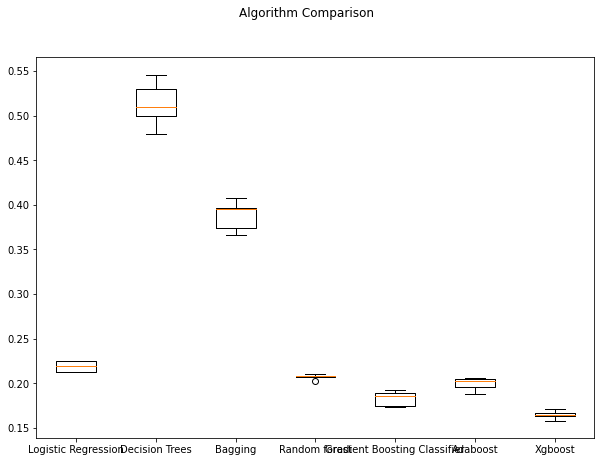

In [34]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

- We can see that XGBoost is giving the highest cross-validated recall followed by Gradient Boosting.
- The boxplot shows that the performance of xgboost is consistent with 1 outlier. 

### Oversampling train data using SMOTE

In [209]:
print("Before Oversampling, counts of label 'Yes': {}".format(np.sum(y_train == 1,0)))
print("Before Oversampling, counts of label 'No': {} \n".format(np.sum(y_train == 0,0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of label 'Yes': {}".format(np.sum(y_train_over == 1,0)))
print("After Oversampling, counts of label 'No': {} \n".format(np.sum(y_train_over == 0, 0)))


print("After Oversampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': default    17703
dtype: int64
Before Oversampling, counts of label 'No': default    56836
dtype: int64 

After Oversampling, counts of label 'Yes': default    56836
dtype: int64
After Oversampling, counts of label 'No': default    56836
dtype: int64 

After Oversampling, the shape of train_X: (113672, 112)
After Oversampling, the shape of train_y: (113672, 1) 



In [246]:
models_over = []  # Empty list to store all the models

# Appending models into the list
models_over.append(
    (
        "Logistic Regression Oversampling",
        LogisticRegression(random_state=1, max_iter=5000),
    )
)
models_over.append(
    ("Decision Trees Oversampling", DecisionTreeClassifier(random_state=1))
)
models_over.append(("Bagging Oversampling", BaggingClassifier(random_state=1)))
models_over.append(
    ("Random forest Oversampling", RandomForestClassifier(random_state=1))
)
models_over.append(
    (
        "Gradient Boosting Classifier Oversampling",
        GradientBoostingClassifier(random_state=1),
    )
)
models_over.append(("Adaboost Oversampling", AdaBoostClassifier(random_state=1)))
models_over.append(
    (
        "Xgboost Oversampling",
        XGBClassifier(random_state=1, eval_metric="logloss", use_label_encoder=False),
    )
)

results_over = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models_over:
    scoring = "f1"
    kfold = StratifiedKFold(
        n_splits=20, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold
    )
    results_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Training Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_train_over, model.predict(X_train_over)) * 100
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

Logistic Regression Oversampling: 71.8172000621244
Decision Trees Oversampling: 82.19262973732624
Bagging Oversampling: 80.23786796880205
Random forest Oversampling: 82.04306486822964
Gradient Boosting Classifier Oversampling: 77.37524463960293
Adaboost Oversampling: 78.41685139263438
Xgboost Oversampling: 77.2080982922973

Training Performance:

Logistic Regression Oversampling: 71.91920613695545
Decision Trees Oversampling: 100.0
Bagging Oversampling: 98.3566753466113
Random forest Oversampling: 100.0
Gradient Boosting Classifier Oversampling: 77.51777042719404
Adaboost Oversampling: 78.19339855021465
Xgboost Oversampling: 77.29783939756493


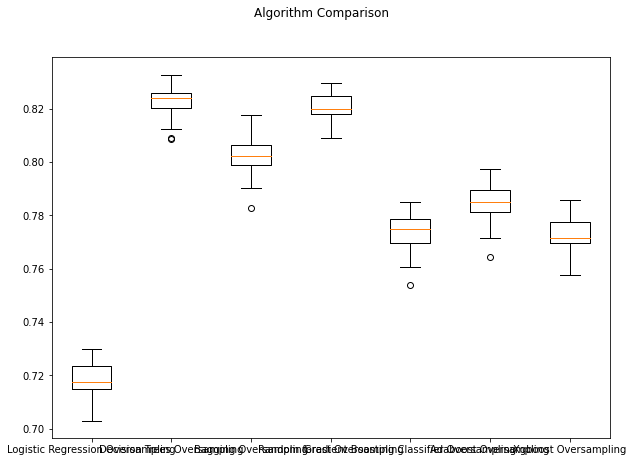

In [247]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_over)
ax.set_xticklabels(names_over)

plt.show()

- We can see that XGBoost is giving the highest cross-validated recall followed by Random forest.
- The boxplot shows that the performance of xgboost is consistent with 2 outlier.

### Undersampling train data using Random Under Sampler

In [38]:
rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [39]:
print("Before Undersampling, counts of label 'Yes': {}".format(np.sum(y_train == 1)))
print("Before Undersampling, counts of label 'No': {} \n".format(np.sum(y_train == 0)))

print("After Undersampling, counts of label 'Yes': {}".format(np.sum(y_train_un == 1)))
print("After Undersampling, counts of label 'No': {} \n".format(np.sum(y_train_un == 0)))

print("After Undersampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Undersampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Undersampling, counts of label 'Yes': default    17703
dtype: int64
Before Undersampling, counts of label 'No': default    56836
dtype: int64 

After Undersampling, counts of label 'Yes': default    17703
dtype: int64
After Undersampling, counts of label 'No': default    17703
dtype: int64 

After Undersampling, the shape of train_X: (35406, 113)
After Undersampling, the shape of train_y: (35406, 1) 



In [40]:
models_un = []  # Empty list to store all the models

# Appending models into the list
models_un.append(
    (
        "Logistic Regression Undersampling",
        LogisticRegression(random_state=1, max_iter=1000),
    )
)
models_un.append(
    ("Decision Trees Undersampling", DecisionTreeClassifier(random_state=1))
)
models_un.append(("Bagging Undersampling", BaggingClassifier(random_state=1)))
models_un.append(
    ("Random forest Undersampling", RandomForestClassifier(random_state=1))
)
models_un.append(
    (
        "Gradient Boosting Classifier Undersampling",
        GradientBoostingClassifier(random_state=1),
    )
)
models_un.append(("Adaboost Undersampling", AdaBoostClassifier(random_state=1)))
models_un.append(
    (
        "Xgboost Undersampling",
        XGBClassifier(random_state=1, eval_metric="logloss", use_label_encoder=False),
    )
)

results_un = []  # Empty list to store all model's CV scores
names_un = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models_un:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scoring, cv=kfold
    )
    results_un.append(cv_result)
    names_un.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Training Performance:" "\n")

for name, model in models_un:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_train_un, model.predict(X_train_un)) * 100
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

Logistic Regression Undersampling: 68.64365136727632
Decision Trees Undersampling: 66.37295634512259
Bagging Undersampling: 64.98338111899827
Random forest Undersampling: 67.8980226786458
Gradient Boosting Classifier Undersampling: 70.23651271545431
Adaboost Undersampling: 65.7063247797791
Xgboost Undersampling: 68.66631724894974

Training Performance:

Logistic Regression Undersampling: 68.99395582669604
Decision Trees Undersampling: 100.0
Bagging Undersampling: 97.75744224142801
Random forest Undersampling: 100.0
Gradient Boosting Classifier Undersampling: 72.30412924363102
Adaboost Undersampling: 66.60453030559792
Xgboost Undersampling: 70.0389764446704


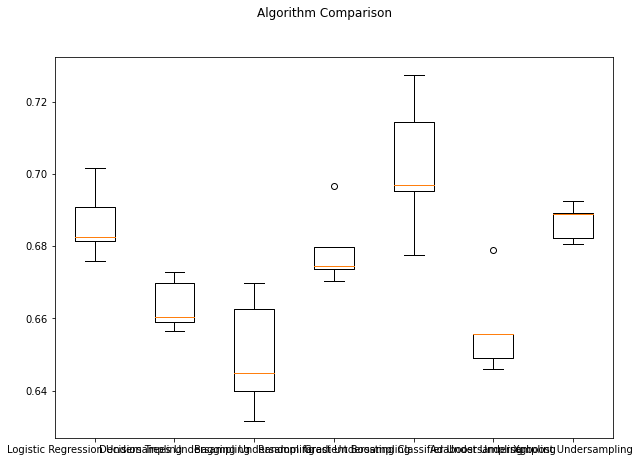

In [41]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_un)
ax.set_xticklabels(names_un)

plt.show()

- We can see that XGBoost is giving the highest cross-validated recall followed by Gradient Boosting.
- The boxplot shows that the performance of xgboost is consistent.

## Hyperparameter Tuning

**Xgboost with Oversampling train data has highest cross-validated recall then Random Forest with Oversampling train data has highest cross-validated recall and then Gradient Boosting with Oversampling train data has highest cross-validated recall. We will tune Random Forest, Gradient Boosting and xgboost models using RandomizedSearchCV. We will also compare the performance of these three models.**

**First, let's create two functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.**

In [42]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [43]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Random Forest Classifier
**Now, let's see if we can get a better model by tuning the random forest classifier. Some of the important hyperparameters available for random forest classifier are:**

- n_estimators: The number of trees in the forest, default = 100.
- max_features: The number of features to consider when looking for the best split. 
- class_weight: Weights associated with classes in the form {class_label: weight}.If not given, all classes are supposed to have weight one.  
- For example: If the frequency of class 0 is 80% and the frequency of class 1 is 20% in the data, then class 0 will become the dominant class and the model will become biased toward the dominant classes. In this case, we can pass a dictionary {0:0.2,1:0.8} to the model to specify the weight of each class and the random forest will give more weightage to class 1. 
- bootstrap: Whether bootstrap samples are used when building trees. If False, the entire dataset is used to build each tree, default=True.
- max_samples: If bootstrap is True, then the number of samples to draw from X to train each base estimator. If None (default), then draw N samples, where N is the number of observations in the train data.
- oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy, default=False.

- Note: A lot of hyperparameters of Decision Trees are also available to tune  Random Forest like max_depth, min_sample_split etc.

Training performance:
    Accuracy    Recall  Precision        F1
0  0.761577  0.774667   0.754904  0.764658
Validation performance:
    Accuracy    Recall  Precision        F1
0  0.700778  0.553321   0.404927  0.467634
CPU times: user 13.4 s, sys: 711 ms, total: 14.1 s
Wall time: 2min 5s


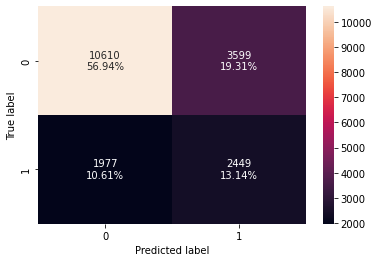

In [211]:
%%time
# Choose the type of classifier.
rf_estimator_tuned = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "max_depth": [2, 4, 6],
    "n_estimators": [10, 17, 25, 33, 41, 48, 56, 64, 72, 80]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=rf_estimator_tuned, param_distributions=parameters, n_jobs = -1, scoring=acc_scorer, cv=10, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

# Set the clf to the best combination of parameters
rf_estimator_tuned = randomized_cv.best_estimator_

# Fit the best algorithm to the data.
rf_estimator_tuned.fit(X_train_over, y_train_over)

# Calculating different metrics
rf_estimator_tuned_model_train_perf = model_performance_classification_sklearn(
    rf_estimator_tuned, X_train_over, y_train_over
)
print("Training performance:\n", rf_estimator_tuned_model_train_perf)

rf_estimator_tuned_model_val_perf = model_performance_classification_sklearn(
    rf_estimator_tuned, X_val, y_val
)
print("Validation performance:\n", rf_estimator_tuned_model_val_perf)

# Creating confusion matrix
confusion_matrix_sklearn(rf_estimator_tuned, X_val, y_val)

### Gradient Boosting Classifier

Training performance 
    Accuracy    Recall  Precision        F1
0  0.873804  0.805229   0.933219  0.864513
Testing performance 
    Accuracy    Recall  Precision        F1
0  0.817065  0.416855   0.690236  0.519792
CPU times: user 6min, sys: 6.45 s, total: 6min 6s
Wall time: 1h 28min 54s


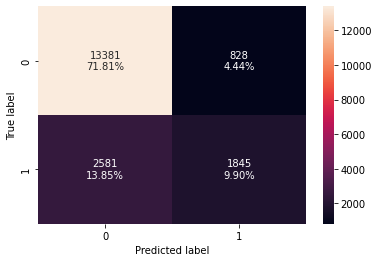

In [210]:
%%time
# Choose the type of classifier.
gbc_tuned = GradientBoostingClassifier(
    init=AdaBoostClassifier(random_state=1), random_state=1
)

# Grid of parameters to choose from
## add from article
parameters = {
    "n_estimators": [100, 150, 200, 250],
    "subsample": [0.8, 0.9, 1],
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=gbc_tuned, param_distributions=parameters, n_jobs = -1, scoring=acc_scorer, cv=10, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

# Set the clf to the best combination of parameters
gbc_tuned = randomized_cv.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train_over, y_train_over)

# Calculating different metrics
gbc_tuned_model_train_perf = model_performance_classification_sklearn(
    gbc_tuned, X_train_over, y_train_over
)
print("Training performance \n", gbc_tuned_model_train_perf)

gbc_tuned_model_val_perf = model_performance_classification_sklearn(
    gbc_tuned, X_val, y_val
)
print("Testing performance \n", gbc_tuned_model_val_perf)

# Creating confusion matrix
confusion_matrix_sklearn(gbc_tuned, X_val, y_val)

### XGBoost Classifier

Training performance 
    Accuracy    Recall  Precision       F1
0  0.515853  0.999877   0.508055  0.67376
Testing performance 
    Accuracy    Recall  Precision        F1
0  0.260585  0.999548   0.243064  0.391037
CPU times: user 9.58 s, sys: 852 ms, total: 10.4 s
Wall time: 7min 3s


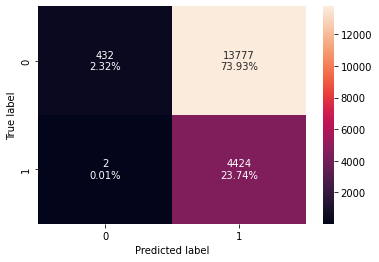

In [212]:
%%time
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1,eval_metric='logloss')

# Grid of parameters to choose from
## add from
parameters = {
    "n_estimators": np.arange(10,100,20),
    "scale_pos_weight":[0,1,2,5],
    "subsample":[0.5,0.7,0.9,1],
    "learning_rate":[0.01,0.1,0.2,0.05],
    "gamma":[0,1,3],
    "colsample_bytree":[0.5,0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=xgb_tuned, param_distributions=parameters, n_jobs = -1, scoring=acc_scorer, cv=10, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

# Set the clf to the best combination of parameters
xgb_tuned = randomized_cv.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train_over, y_train_over)

# Calculating different metrics
xgb_tuned_model_train_perf = model_performance_classification_sklearn(
    xgb_tuned, X_train_over, y_train_over
)
print("Training performance \n", xgb_tuned_model_train_perf)

xgb_tuned_model_val_perf = model_performance_classification_sklearn(
    xgb_tuned, X_val, y_val
)
print("Testing performance \n", xgb_tuned_model_val_perf)

# Creating confusion matrix
confusion_matrix_sklearn(xgb_tuned, X_val, y_val)

#### Decision Tree

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision       F1
0  0.773652  0.544962    0.52253  0.53351


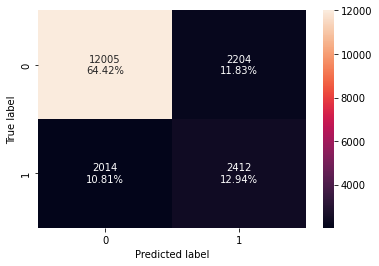

In [159]:
# Fitting the model
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train, y_train)

# Calculating different metrics
dtree_model_train_perf = model_performance_classification_sklearn(
    d_tree, X_train, y_train
)
print("Training performance:\n", dtree_model_train_perf)
dtree_model_test_perf = model_performance_classification_sklearn(d_tree, X_val, y_val)
print("Testing performance:\n", dtree_model_test_perf)
# Creating confusion matrix
confusion_matrix_sklearn(d_tree, X_val, y_val)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.736732  0.504293   0.451456  0.476414


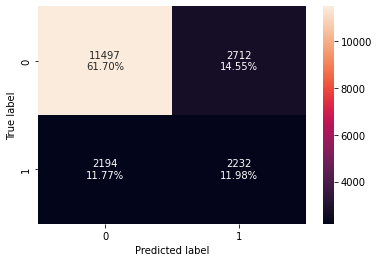

In [253]:
# Fitting the model
d_tree_over = DecisionTreeClassifier(random_state=1)
d_tree_over.fit(X_train_over, y_train_over)

# Calculating different metrics
dtree_model_train_perf_over = model_performance_classification_sklearn(
    d_tree_over, X_train_over, y_train_over
)
print("Training performance:\n", dtree_model_train_perf_over)
dtree_model_test_perf_over = model_performance_classification_sklearn(d_tree_over, X_val, y_val)
print("Testing performance:\n", dtree_model_test_perf_over)
# Creating confusion matrix
confusion_matrix_sklearn(d_tree_over, X_val, y_val)

## Comparing all tuned models

In [47]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        rf_estimator_tuned_model_train_perf.T,
        gbc_tuned_model_train_perf.T,
        xgb_tuned_model_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Random Forest Tuned with Random Search",
    "Gradient Boosting Tuned with Random Search",
    "XGBoost Tuned with Random Search",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Random Forest Tuned with Random Search,Gradient Boosting Tuned with Random Search,XGBoost Tuned with Random Search
Accuracy,0.832113,0.870267,0.514040
Recall,0.790467,0.799212,0.999947
Precision,0.862289,0.931602,0.507121
F1,0.824818,0.860344,0.672954


In [48]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        rf_estimator_tuned_model_val_perf.T,
        gbc_tuned_model_val_perf.T,
        xgb_tuned_model_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Random Forest Tuned with Random Search",
    "Gradient Boosting Tuned with Random Search",
    "XGBoost Tuned with Random Search",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Random Forest Tuned with Random Search,Gradient Boosting Tuned with Random Search,XGBoost Tuned with Random Search
Accuracy,0.769198,0.814972,0.259190
Recall,0.438997,0.416177,0.999096
Precision,0.516618,0.680710,0.242660
F1,0.474655,0.516545,0.390481


- The xgboost model tuned using Random search is giving the best validation recall of 0.995 but it has the low values of validation precision.
- Let's check the model's performance on test set and then see the feature importance from the tuned xgboost model

#### Performance on the test set

In [49]:
# Calculating different metrics on the test set
model_grid_test = model_performance_classification_sklearn(xgb_tuned, X_test, y_test)
print("Test performance:")
model_grid_test

NameError: ignored

- The performance on test data is generalised

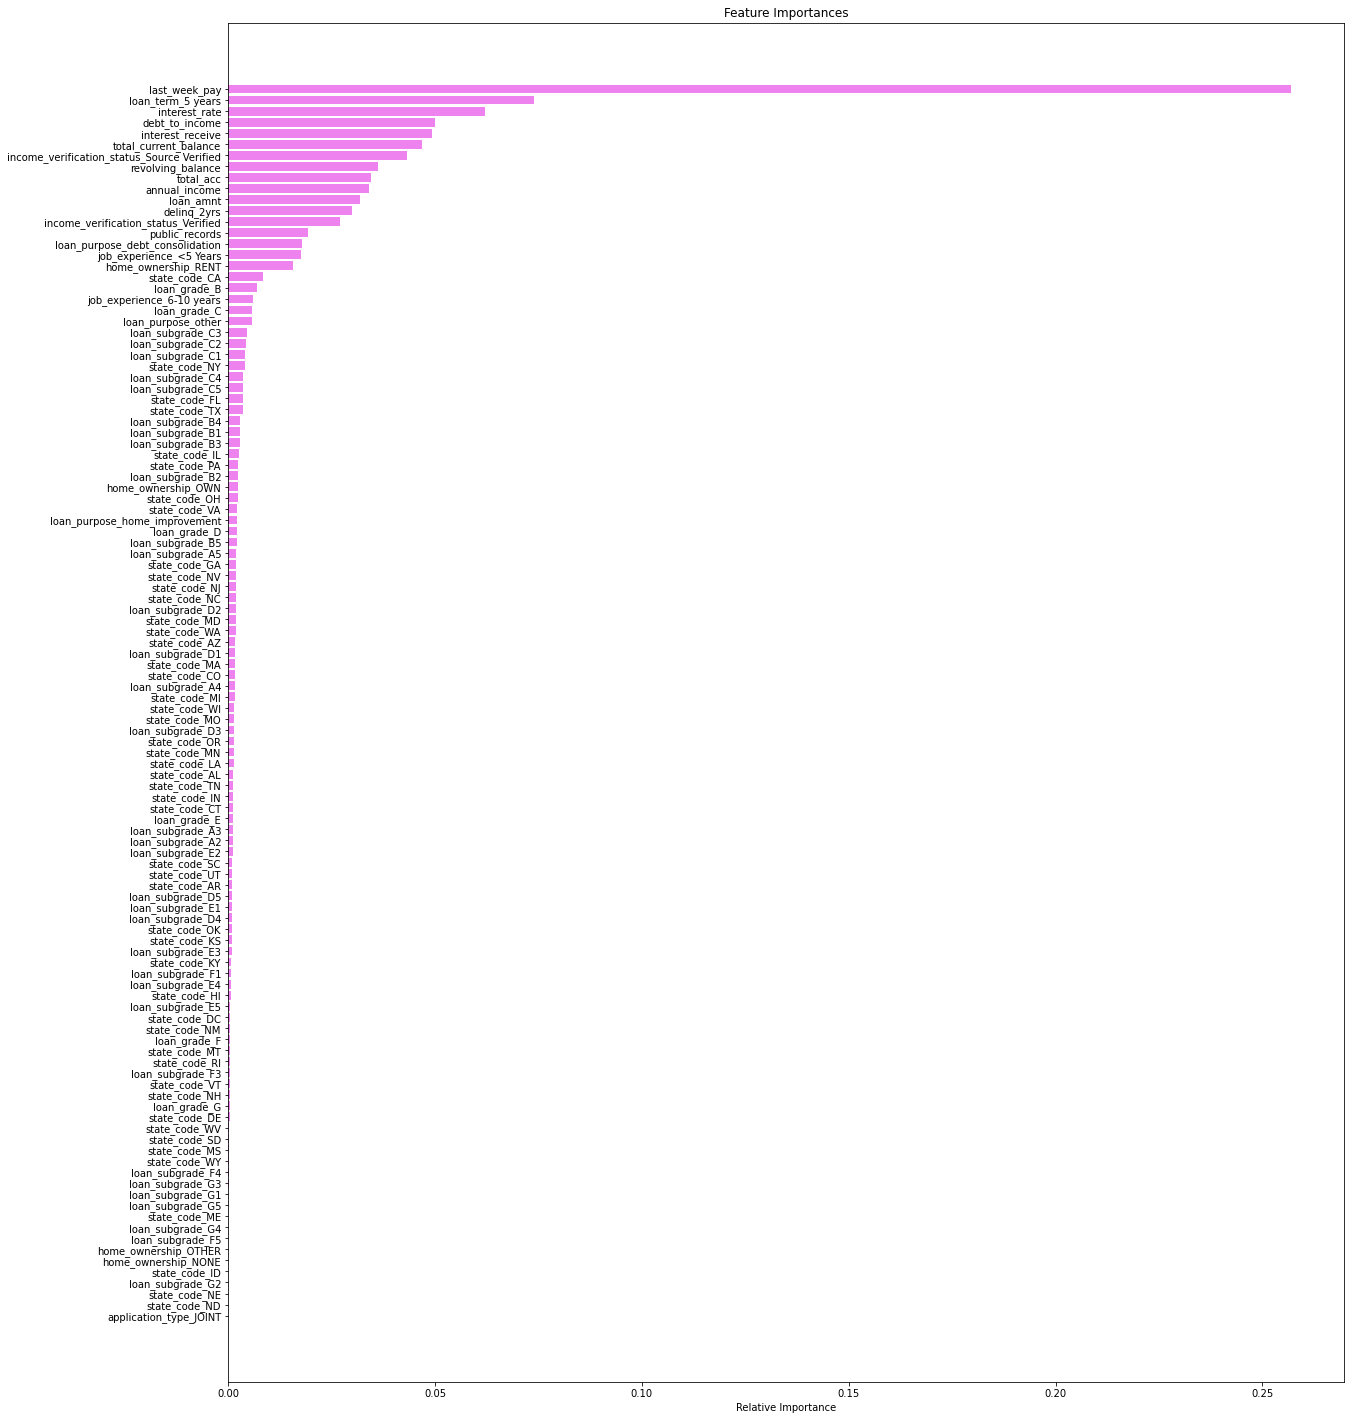

In [254]:
feature_names = X.columns
importances = d_tree_over.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 25))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- Total_Trans_Ct is the most important feature, followed by Total_Trans_Amt and Total_Relationship_Count.

## **Predict Test Data**

Best Threshold=1.000000, G-Mean=0.643


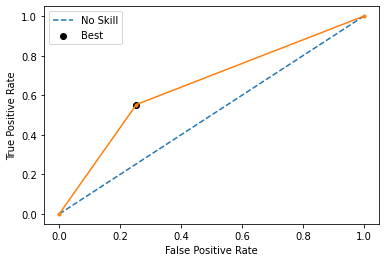

In [235]:
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat = rf_estimator_tuned.predict(X_val)
# keep probabilities for the positive outcome only
yhat = yhat[:]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [236]:
test_predict = rf_estimator_tuned.predict(df_test)
#test_predict = (test_predict > thresholds[ix])

In [237]:
res = pd.DataFrame(test_predict)
#res.index = Data_test.index # its important for comparison


In [238]:
res.head

<bound method NDFrame.head of        0
0      1
1      0
2      0
3      0
4      0
...   ..
39928  0
39929  0
39930  0
39931  0
39932  0

[39933 rows x 1 columns]>

In [239]:
res.columns = ["default"]
final_result = pd.merge(Data_test, res, left_index=True, right_index=True)

In [240]:
final_result.head

<bound method NDFrame.head of              ID  loan_amnt  ... total_revolving_limit  default
0       4855329      12000  ...               25800.0        1
1      66862420      12000  ...               23600.0        0
2       3637416      15000  ...               34100.0        0
3      53682249      12000  ...               21700.0        0
4      53937165      20150  ...               12000.0        0
...         ...        ...  ...                   ...      ...
39928  57779318       5000  ...               26100.0        0
39929  59742362       1800  ...               29200.0        0
39930  72657145      15200  ...               45400.0        0
39931  15220189      14425  ...               19700.0        0
39932  21810584      27000  ...               33500.0        0

[39933 rows x 23 columns]>

In [241]:
final_result["default"].value_counts()

0    27122
1    12811
Name: default, dtype: int64

In [242]:
final_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39933 entries, 0 to 39932
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          39933 non-null  int64  
 1   loan_amnt                   39933 non-null  int64  
 2   loan_term                   39933 non-null  object 
 3   interest_rate               39933 non-null  float64
 4   loan_grade                  39933 non-null  object 
 5   loan_subgrade               39933 non-null  object 
 6   job_experience              37844 non-null  object 
 7   home_ownership              39933 non-null  object 
 8   annual_income               39933 non-null  float64
 9   income_verification_status  39933 non-null  object 
 10  loan_purpose                39933 non-null  object 
 11  state_code                  39933 non-null  object 
 12  debt_to_income              39933 non-null  float64
 13  delinq_2yrs                 399

In [243]:
final_result["default"] = final_result["default"].astype(int)

In [244]:
final_result["default"].value_counts()

0    27122
1    12811
Name: default, dtype: int64

In [245]:
final_result.to_csv("/content/drive/MyDrive/Colab Notebooks/Data/Hackathons/prediction_results.csv", columns=["ID" , "default"],index=False)